#### Grism analysis
This script reads a FITS image containing a dispersed grism spectrum and applies wavelength and gain calibration read from a previously generated calibration file. It displays the image and extraction subimage, uncalibrated and calibrated spectra, gain curve, and some line fits. It saves the spectrum obect as a csv.

V. 1.0 (9 May 2024) CHR. 


## imports and definitions

In [131]:
from grism_utils import *
import pandas as pd
import numpy as np
import numpy.ma as ma
from astropy.io import fits
from astropy.io.fits import getdata
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.ndimage import maximum_filter1d
from scipy.signal import medfilt, find_peaks, detrend
from datetime import datetime
import smplotlib
import os
import glob


balmer = np.array([397.0, 410.17, 434.05, 486.14, 656.45])
deg = np.pi/180.
h = const.h
c = const.c
k = const.k_B


In [132]:
# Define location of your data

image_dir = '/Users/crinkosk/pyscope/pyscope/pyscope/grism/temp_images/2024-05-10/'

cal_dir = '/Users/crinkosk/pyscope/pyscope/pyscope/grism/temp_cal/'

#choose an image manually:
image_name = 'grismCalibration_HD116608_180s_hrg_0_cal.fts'

#choose a cal file manually:
cal_name = 'hrg_grism_cal(master).csv'

In [133]:
def read_calfile(fname):
    ''' Reads grism calibration file (.csv), extracts header line, subimage box, rotation angle, 
    and coefficients to generate functions that convert pixels to wavelength and gain vs wavelength'''
    with open(fname,'r') as f:
        lines = f.read().split('\n')
        hdr_line = lines[0]
        box = [int(x) for x in lines[1].split(',')]
        angle = float(lines[2])
        wavelength_coefficients = np.array([float(x) for x in lines[3].split(',')])
        gain_coefficients = np.array([float(x) for x in lines[4].split(',')] )    
    return(hdr_line, box, angle, wavelength_coefficients, gain_coefficients)

def read_jacoby_file(fname):
        ''' Reads a standard Jacoby .csv file, packs wavelength and amplitude arrays into spectrum object '''
        wave_ref, spec_ref = np.loadtxt(fname, unpack=True, \
        comments='#',usecols=(0,1),dtype = float)
        spec_ref /= np.max(spec_ref)
        jacoby_spectrum = np.vstack([wave_ref,spec_ref])  # contains wavelength and amp. arrays
        return jacoby_spectrum

# Read science image, calibration file, and corresponding Jacoby spectrum if available

In [134]:
# Get the data:

# Set flag to create a calibration file (cf. calibrating a raw image using an existing cal file)
do_calibrate = False

grism_image = image_dir + image_name
if os.path.exists(grism_image):
    print('Found grism image: %s' % grism_image)
    im, hdr = getdata(grism_image, 0, header=True)
    object_name  = hdr['OBJECT']
    obs_date = hdr['DATE-OBS']
else:
    print('Cannot find %s, stopping' % grism_image)
    raise StopExecution  

if not do_calibrate:
    # Specify an existing calibration file
    cal_file = cal_dir + cal_name
    if os.path.exists(cal_file):
        cal_hdr, box, rot_angle, wavelength_coefficients, gain_coefficients = read_calfile(cal_file)
        f_wave = np.poly1d(wavelength_coefficients)
        f_gain = np.poly1d(gain_coefficients)
        print('Found calibration file: %s' % os.path.basename(cal_file),' ',cal_hdr)
    else:
        print('Error: Cannot find calibration file: %s' % cal_file)
        raise StopExecution  
    
# Check for matching Jacoby image
jacoby_dir = image_dir
jacoby_csv = '%s%s-Jacoby-spec.csv' % (jacoby_dir,object_name)
if os.path.exists(jacoby_csv): 
    print('Found matching Jacoby spectrum file: %s' % jacoby_csv)
    jacoby = True
    jacoby_spectrum = read_jacoby_file(jacoby_csv)
else:
    jacoby = False
    jacoby_spectrum = np.array([])

print('Object: %s, Date: %s' % (object_name,obs_date))

Found grism image: /Users/crinkosk/pyscope/pyscope/pyscope/grism/temp_images/2024-05-10/grismCalibration_HD116608_180s_hrg_0_cal.fts
Found calibration file: hrg_grism_cal(master).csv   Grism calibration created using python
Object: HD116608, Date: 2024-05-10T07:01:43.29


# Allow user to edit subimage box


Creating subimage...
Drawing box at 200,995 with dimensions 1700,40
Full image dimensions: 2048,2048
Rotation angle = 359.7 deg
Maximum ADU count in subimage = 3170
HD116608


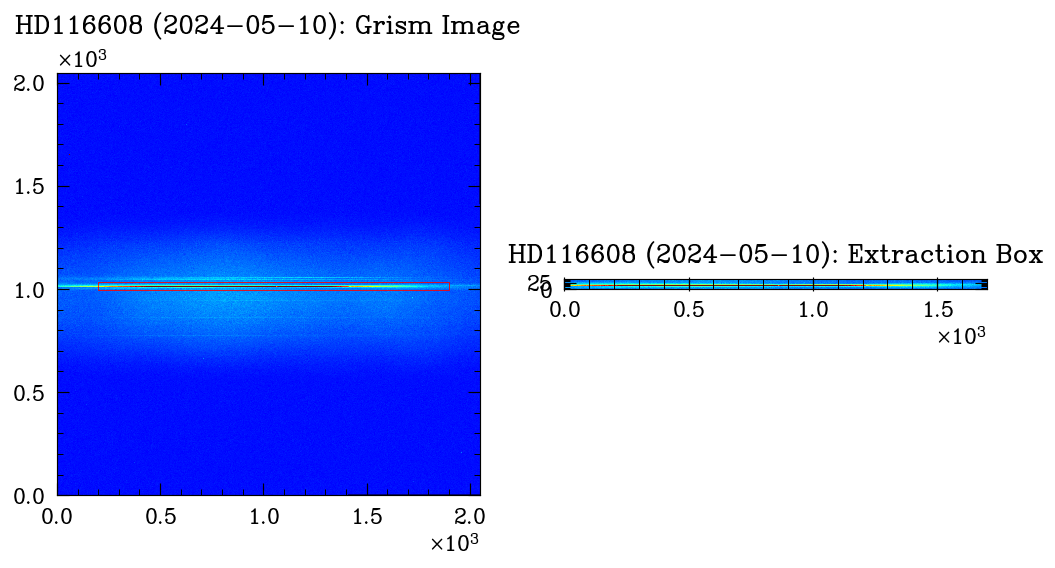

In [135]:
# defining subimage box dimensions as specified by user
print('Creating subimage...')
xi,yi = im.shape
# use this to manually set the box dimensions, otherwise the box will be set by the calibration file
manual = False
if manual:
    xstart = 550
    ystart = 925
    xwidth = 1250
    ywidth = 50
    rotangle = 0
    mybox  = [xstart,ystart,xwidth,ywidth]
else:
    mybox = box
    rotangle = rot_angle
    xstart,ystart,xwidth,ywidth = mybox
    
print(f'Drawing box at {xstart},{ystart} with dimensions {xwidth},{ywidth}')
print(f'Full image dimensions: {xi},{yi}')
print(f'Rotation angle = {rotangle} deg')

# Instantiate with rotation angle and subimage box
B = grism_utils(grism_image,cal_file,rotangle,mybox,f_wave,f_gain)

# Create subimage using optional box parameters
subim,transim = B.create_box()
xs,ys = subim.shape
zmax = np.max(subim)
print(f'Maximum ADU count in subimage = {zmax}')

# Plot subimage
object_name, obs_date,telescope,camera,title,im,rot_angle, box, _,_ = B.summary_info()
fig = B.plot_box(image=transim,subim=subim,box=mybox,cmap='jet')
print(object_name)   

# Show the uncalibrated spectrum:  uncalibrated amplitude versus pixel

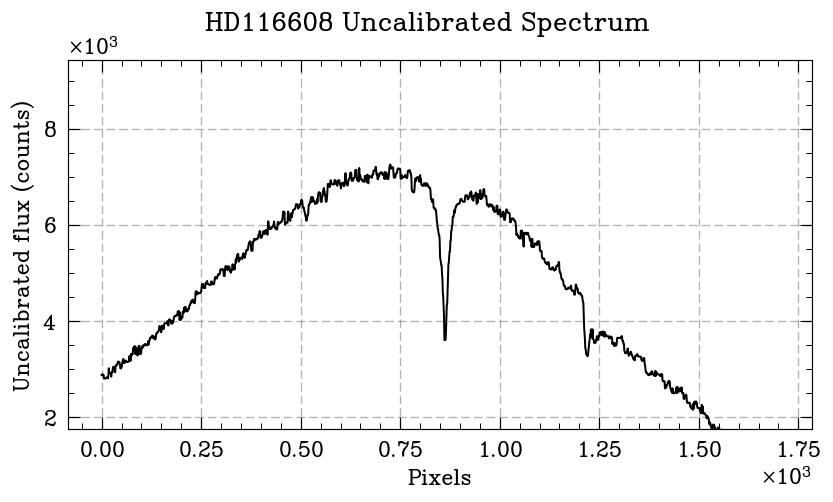

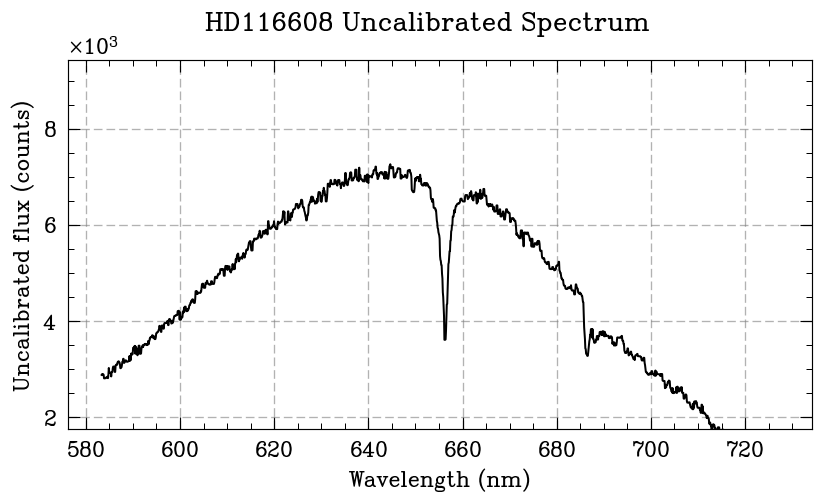

In [136]:
spectrum = B.calibrate_spectrum(subim,norm=False)

fig = B.plot_spectrum(spectrum, xaxis='pixel', yaxis='uncal', subrange = slice(0,len(spectrum[0])),\
                    title='%s Uncalibrated Spectrum' % object_name, medavg = 5,xlims =[0,0],ylims =[0,0])
fig = B.plot_spectrum(spectrum, xaxis='wave', yaxis='uncal',plot_balmer=False, subrange = slice(0,len(spectrum[1])),\
                    title='%s Uncalibrated Spectrum' % object_name, medavg = 5,xlims =[0,0],ylims =[0,0]) 

# Show the gain curve, which connects flux to intensity and pixel to wavelength

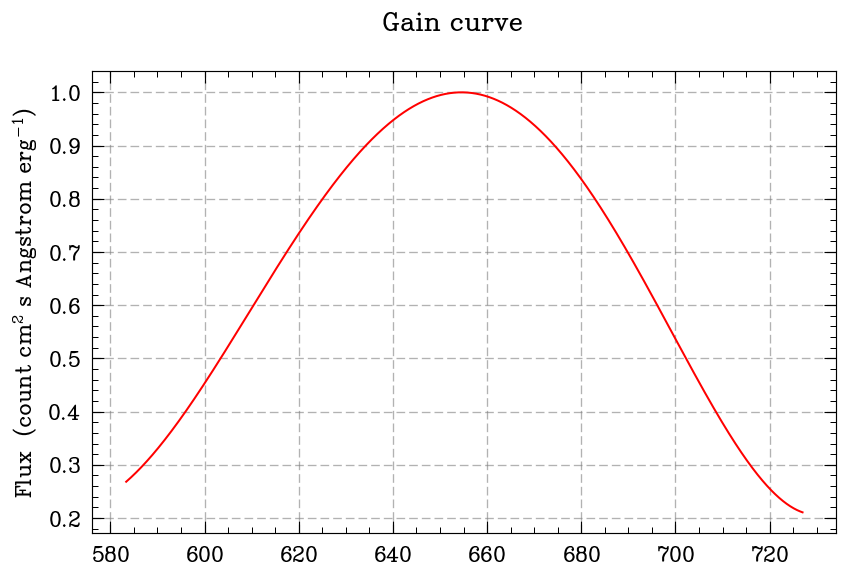

In [137]:
fig = B.plot_gain_curve(spectrum,color='r',title='Gain curve')


# Show the calibrated spectrum: flux in physical units versus wavelength in nm

You may need to adjust the 'calib' parameter if you do not see your spectrum plotted properly. If you are using the defualt calibration, which does not calculate accurate flux, set calib='default'. If you are using a custom calibration file from grism_gain.ipynb, set calib='custom'. 

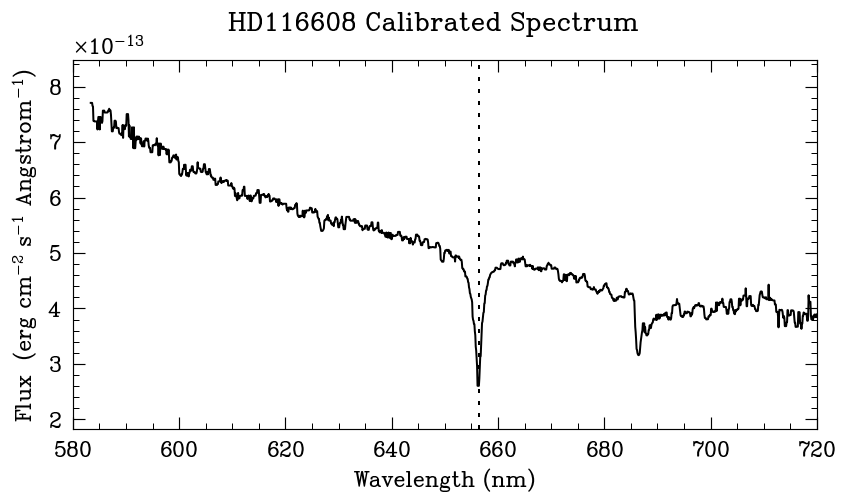

In [138]:
fig = B.plot_spectrum(spectrum, xaxis='wave', yaxis='cal',medavg=7, title='%s Calibrated Spectrum' % object_name,
xlims=[580,720],plot_balmer=True,grid=False)


# Fit prominent spectral lines with Gaussians

Wave_ctr = 687.1 +/- 0.1 nm, FWHM = 2.7 +/- 0.2 nm



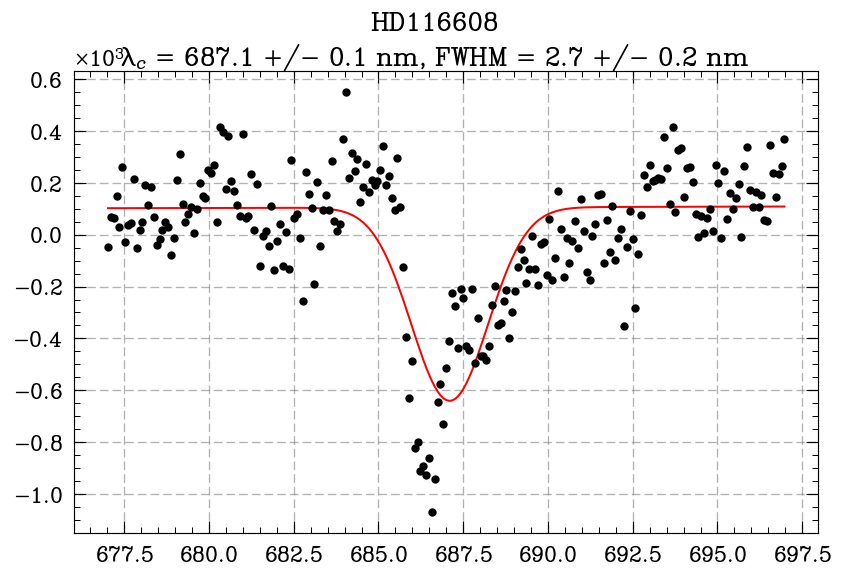

In [139]:
# Fit a line with Gaussian and  plot
wave_min = 677 ; wave_max = 697
params, wave, amp, amp_mod = B.fit_spectral_line(spectrum,wave_min,wave_max)
wave_ctr,wave_ctr_err,fwhm,fwhm_err,a,a_err = params
print('Wave_ctr = %.1f +/- %.1f nm, FWHM = %.1f +/- %.1f nm\n' % (wave_ctr,wave_ctr_err, fwhm, fwhm_err))
fig = B.plot_spectral_line(wave,amp,amp_mod,wave_ctr,wave_ctr_err,fwhm,fwhm_err,color='red',title=object_name)

Wave_ctr = 656.3 +/- 0.0 nm, FWHM = 2.2 +/- 0.1 nm



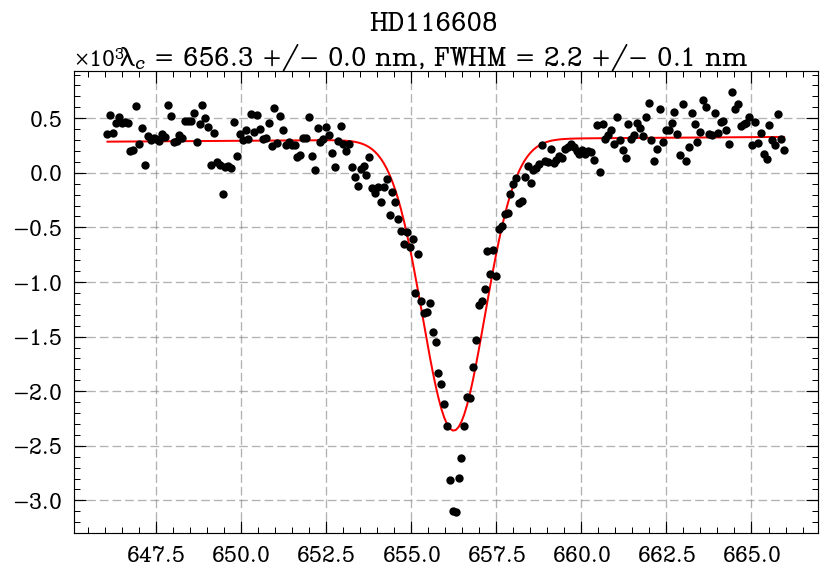

In [140]:
# Fit a line with Gaussian and  plot
wave_min = 646 ; wave_max = 666
params, wave, amp, amp_mod = B.fit_spectral_line(spectrum,wave_min,wave_max)
wave_ctr,wave_ctr_err,fwhm,fwhm_err,a,a_err = params
print('Wave_ctr = %.1f +/- %.1f nm, FWHM = %.1f +/- %.1f nm\n' % (wave_ctr,wave_ctr_err, fwhm, fwhm_err))
fig = B.plot_spectral_line(wave,amp,amp_mod,wave_ctr,wave_ctr_err,fwhm,fwhm_err,color='red',title=object_name)

## write spectrum to csv

In [141]:

df = pd.DataFrame(spectrum.T)
df.columns = ['Pixel', 'Wavelength', 'Uncalibrated_flux', 'Calibrated_flux']
df.to_csv(f'/Users/crinkosk/pyscope/pyscope/pyscope/grism/temp_spec/{object_name}Spec.csv')
